In [1]:
import tensorflow as tf
from keras.models import load_model
from keras.models import Model
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input, Activation
import numpy as np 
from skimage.measure import compare_ssim
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import time
import keras
import random
from sklearn.metrics import accuracy_score
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from IPython.display import clear_output
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras_ex.gkernel import GaussianKernel, GaussianKernel2, GaussianKernel3
from math import log10, sqrt 
import cv2 
from deap import algorithms
from deap import base
from deap import creator
from deap import tools

Using TensorFlow backend.


In [2]:
np.random.seed(1)
random.seed(1)

In [3]:
INDIVIDUALS = 50
MAX_GEN = 10000
P_CROSS = 0.6
P_MUTATION = 0.1
LEN = 784
MNIST_IMG = 28

In [4]:
def euclidean(s):
    # https://stackoverflow.com/questions/1401712/how-can-the-euclidean-distance-be-calculated-with-numpy
    # pass s=a-b as argument to the function
    return np.linalg.norm(s)

def euc_fitness(individual, gt, pred, target, l1=0.5, l2=0.5, N = 50, n_classes=10):
    # petras fitness fucntion
    #print(l1*euclidean(individual-target)/N, l2*euclidean(pred-label)/n_classes)
    return -(l1*euclidean(individual-gt)/N + l2*euclidean(pred-target)/n_classes)

def computing_SSIM(individual,target):
    target = target.reshape(28,28)
    individual = individual.reshape(28,28)
    if individual.shape == target.shape:
        (score, diff) = compare_ssim(individual, target, full=True)
    else:
        print(target.shape)
        print(individual.shape)
    return score

def calculate_fitness(ind,target_image,label,l1=0.5, l2=0.5, N=50, num_classes=10):
    # predict the population
    predictions=model.predict(ind.reshape(1,28,28,1)) 
    # po is the ground truth prediction, so for label = 0, it will be prediciton[0]
    predictions=predictions[0]
    po=predictions[label]
    # set that value to 0
    predictions[label]=0
    # take next highest one
    pd = np.max(predictions)
    diff = pd-po
    return l1*computing_SSIM(ind.reshape(28,28),target_image) + l2*(diff)

def pop_fitness(pop, target, predictions, label):
    return [calculate_fitness(p, target, pred, label) for p, pred in zip(pop, predictions)]

def flatten(imgs):
    return np.array([im.flatten() for im in imgs])

def gaussian_noise():
    # draw one sample of noise from zero mean 1 variance Gaussian
    return np.random.normal(0, np.sqrt(0.01))

def p_noise(x):
    # add noise given probability
    if P_MUTATION > np.random.uniform():
          return x + gaussian_noise()
    else:
        return x

def add_noise(image):
    # define vectorized function to apply to image
    noise_v = np.vectorize(p_noise)
    return noise_v(image)

def k_crossover(im1, im2, k=2):
    c1, c2 = [], []
    # get k crossover points
    points = sorted([np.random.randint(0, 783, 1) for p in range(k)])
    im_1_split = np.split(im1, [int(p) for p in points])
    im_2_split = np.split(im2, [int(p) for p in points])
    
    # alternate between lists to realise crossover (theres got to be a more clever way to do this)
    for i in range(k+1):
        if i % 2 == 0:
            c1.append(im_1_split[i])
            c2.append(im_2_split[i])
        else:
            c1.append(im_2_split[i])
            c2.append(im_1_split[i])
    return np.concatenate(c1, axis=0), np.concatenate(c2, axis=0)

def tournament(pop, predictions, ground_truth, target, k=3):
    indices = np.random.choice(range(len(pop)), k, replace=False)
    individuals = pop.take(indices, axis=0)
    scores = [euc_fitness(ind, ground_truth, p, target) for ind ,p in zip(individuals, predictions)]
    index_max = np.argmax(scores) 
    winner = individuals[index_max]
    return winner

def check_adv_termination(ind, label,ground_truth, model):
    # individual - the best one from the generation
    # label - class we want
    # ground_truth - the image (28,28)
    # model we are using 
    dist = 1-compare_ssim(ind.reshape(MNIST_IMG,MNIST_IMG),ground_truth.reshape(MNIST_IMG,MNIST_IMG))
    predictions= model.predict(ind.reshape(1,MNIST_IMG,MNIST_IMG,1) / 255.0)
    predicted_label= np.argmax(predictions[0])
    if label != predicted_label and dist < 0.001:
        print("FOUND ADVERSARIAL")
        print(f"Fitness of the adversarial {calculate_fitness(model,ind,ground_truth,label)}")
        return individual
    return None 


def init_pop_from_sample(n, num, data, labels):
    indices = np.where(labels==num)[0]
    index = np.random.choice(indices, 1)
    sample = np.take(data, index, axis=0)
    x = np.array([add_noise(sample) for i in range(n)])
    return x.reshape(n, 784), sample

In [5]:
''' my part of the code ''' 
''' I know it is ugly, I will fix it . this is the intial version'''
# from Goorge Clooney paper
def quadrant_crossover(parent_1,parent_2):
    # reshape parents
    parent_1,parent_2= parent_1.reshape((MNIST_IMG,MNIST_IMG)), parent_2.reshape((MNIST_IMG,MNIST_IMG))
    # quadrants for both parents
    p1,p2,p3,p4,q1,q2,q3,q4 = [],[],[],[],[],[],[],[]
    child1, child2 = [],[]
    # getting random (x,y) point in 2D matrix
    x,y = np.random.randint(0,MNIST_IMG-1), np.random.randint(0,MNIST_IMG-1)  

    # choose which quadrant we want to crossover
    N = np.random.randint(0,3)
    #make quadrants
    for i in range(MNIST_IMG):
        if (i<=x):
            p1.append(parent_1[i][:y+1])
            p2.append(parent_1[i][y+1:])
            q1.append(parent_2[i][:y+1])
            q2.append(parent_2[i][y+1:])
        else:
            p3.append(parent_1[i][:y+1])
            p4.append(parent_1[i][y+1:])
            q3.append(parent_2[i][:y+1])
            q4.append(parent_2[i][y+1:])

    if (N==0):
        ch1 = connect_quadrants(p1,q2,q3,q4)
        ch2 = connect_quadrants(q1,p2,p3,p4)
    elif (N==1):
        ch1 = connect_quadrants(q1,p2,q3,q4)
        ch2 = connect_quadrants(p1,q2,p3,p4)
    elif (N==2):
        ch1 = connect_quadrants(q1,q2,p3,q4)
        ch2 = connect_quadrants(p1,p2,q3,p4)
    else:
        ch1 = connect_quadrants(q1,q2,q3,p4)
        ch2 = connect_quadrants(p1,p2,p3,q4)

    return ch1,ch2

def connect_quadrants(q1,q2,q3,q4):
    left = np.concatenate((q1,q3))
    right = np.concatenate((q2,q4))
    image = np.concatenate((left,right),axis=1)
    return image.flatten()


def multi_crossover(parent1,parent2,target):
    pop= []
    # 2-k crossover
    pop.append(k_crossover(parent1, parent2))
    # Gorge Clooney crossover
    pop.append(quadrant_crossover(parent1,parent2))
    # uniform crossover
    pop.append(k_crossover(parent1, parent2,1))
    # SSIM similarity 
    flattened_list = [y for x in pop for y in x] # need to flatten the list because pop is list of lists, cause every crossover function returns 2 obj
    ssim = [computing_SSIM(ind,target) for ind in flattened_list ]
    # taking the index of largest two score
    id1=np.argmax(ssim)
    ssim[id1]=0
    id2 = np.argmax(ssim)
    #returning parents
    return flattened_list[id1],flattened_list[id2]

In [6]:
def return_best_individual(sample_population,fitness):
    index = np.argmax(fitness)
    best = sample_population[index]
    return best

def choose_better_child(ch1, ch2,ground_truth,label,model):
    # I named it better child, but we choose by this parents as well
    ch1_f = calculate_fitness(model,ch1.reshape(MNIST_IMG,MNIST_IMG),ground_truth.reshape(MNIST_IMG,MNIST_IMG),label)
    ch2_f = calculate_fitness(model,ch2.reshape(MNIST_IMG,MNIST_IMG),ground_truth.reshape(MNIST_IMG,MNIST_IMG),label)
    # change this into ternary operator
    if ch1_f>ch2_f:
        return ch1
    else:
        return ch2

In [9]:
# load flatten and normalize mnist
#(x_train, y), (x_test, y_t) = tf.keras.datasets.mnist.load_data()
#X = flatten(x_train)
#X_test = flatten(x_test)
#X = np.array([x/255. for x in X])
#X_t = np.array([x/255. for x in X_test])

In [10]:
inp = Input(shape=(28,28,1))
conv1 = Conv2D(32, (3,3),activation='relu')(inp)
conv2 = Conv2D(32, (3,3),activation='relu')(conv1)
max_pool1 = MaxPooling2D(pool_size=(2, 2))(conv2)
drop = Dropout(0.25)(max_pool1)
flat =  Flatten()(drop)
dense1 = Dense(128,activation="relu")(flat)
drop = Dropout(0.5)(dense1)
predictions = Dense(10,activation="softmax")(drop)
model = Model(inputs=[inp], outputs=[predictions])
model.compile(optimizer='Adadelta', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])
model.load_weights('CNN_MNIST.h5')
#print(model)
#model.summary()

In [11]:
'''
def sample_test_set(percentage,X_test,X_test_scaled,y_test,imsize,channels,num_clusters, num_classes,num_samples):
    original = []
    adversarial = []
    original_y = []
    adversarial_y = []
    for sample_class in range(num_classes):
        labels = y_test[(y_test==sample_class).reshape(num_samples)]
        samples_orig = X_test[(y_test==sample_class).reshape(num_samples)]
        samples = X_test_scaled[(y_test==sample_class).reshape(num_samples)]
        samples = samples.reshape((samples.shape[0],imsize*imsize*channels))
        kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit_predict(samples)
        for cluster in range(num_clusters):
            subsamples = np.where(kmeans==cluster)[0]
            ori, adv = train_test_split(subsamples,random_state=0, test_size = percentage ,shuffle=True)
            original.extend(samples_orig[ori])
            original_y.extend(labels[ori])
            adversarial.extend(samples_orig[adv])
            adversarial_y.extend(labels[adv])
    return np.array(original), np.array(adversarial), np.array(original_y), np.array(adversarial_y)

discard, subsample, discard_y, subsample_y = sample_test_set(0.1,X_test,X_t,y_t,28,1,5,10,10000)
print('subsample_y.shape:', subsample_y.shape)
subsample_sc = subsample / 255.0
y_pred_subsample = model.predict(np.expand_dims(subsample_sc.reshape(subsample_sc.shape[0],28,28),axis=3))
original,adversarial, original_y, adversarial_y = sample_test_set(0.1,subsample,subsample_sc,subsample_y,28,1,5,10,1021)
print('original.shape:',original.shape)
print('adversarial.shape:', adversarial.shape)
print('adversarial.shape:', adversarial_y.shape)
'''
file_ = open('subset_cnn', 'rb')
original = pickle.load(file_)
adversarial = pickle.load(file_)
original_y = pickle.load(file_)
adversarial_y = pickle.load(file_)
file_.close()

In [12]:
def main(image, label):
    pop = tbx.population(n=INDIVIDUALS)


    # Evaluate the entire population
    fitnesses = list(map(tbx.evaluate, pop))
    
    # Set fitnesses to individuals
    for ind, fit in zip(pop, fitnesses):
        ind.fitness.values = fit
        
   # loop for the number of generation we need
    for g in range(MAX_GEN):
        
        preds = np.argmax(model.predict(np.array(pop).reshape(50, 28,28,1)/255.), axis=1)

        for ind, pred in zip(pop, preds):
            if pred != label:
                print(f'adverserial class {pred} for label {label} found in {g} generations!')
                return ind, g
            
        if g % 250 == 0:
            print(f'fitting gen: {g} with mean fitness value:', np.mean(fitnesses))
            
        # Select the next generation individuals
        offspring = tbx.select(pop, len(pop))
        # Clone the selected individuals
        offspring = list(map(tbx.clone, offspring))

        # Apply crossover and mutation on the offspring
        for child1, child2 in zip(offspring[::2], offspring[1::2]):
            if np.random.uniform() < P_CROSS:
                
                tbx.mate(child1.reshape(784), child2.reshape(784))
                del child1.fitness.values
                del child2.fitness.values

        for mutant in offspring:
            tbx.mutate(mutant.reshape(784))
            del mutant.fitness.values
        
        # Evaluate the individuals with an invalid fitness
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = list(map(tbx.evaluate, invalid_ind))
        
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit


        pop[:] = offspring
    print('Max amount of generations reached')
    return return_best_individual(pop,fitnesses), g

C:\Users\Cyril de Kock\Anaconda3\lib\site-packages\deap\creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
C:\Users\Cyril de Kock\Anaconda3\lib\site-packages\deap\creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
C:\Users\Cyril de Kock\Anaconda3\lib\site-packages\deap\creator.py:141: RuntimeWarning: A class named 'Strategy' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


fitting gen: 0 with mean fitness value: -0.5
adverserial class 2 for label 0 found in 16 generations!
found [2] in 3.28125 seconds


C:\Users\Cyril de Kock\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
  from ipykernel import kernelapp as app


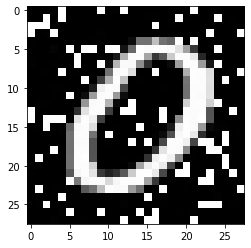

fitting gen: 0 with mean fitness value: -0.4999999701976776
adverserial class 8 for label 0 found in 14 generations!
found [8] in 2.546875 seconds


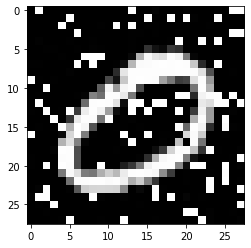

fitting gen: 0 with mean fitness value: -0.49999555945396423
adverserial class 8 for label 0 found in 13 generations!
found [8] in 2.8125 seconds


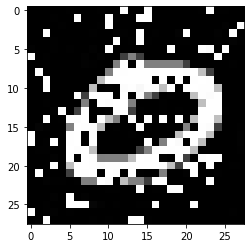

fitting gen: 0 with mean fitness value: -0.5
adverserial class 2 for label 0 found in 6 generations!
found [2] in 1.453125 seconds


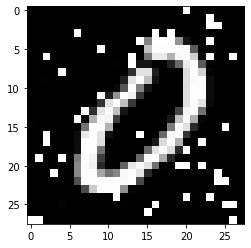

fitting gen: 0 with mean fitness value: -0.4999965727329254
adverserial class 2 for label 0 found in 5 generations!
found [2] in 1.09375 seconds


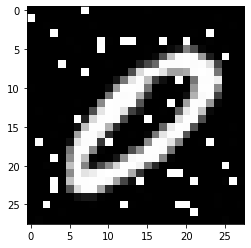

fitting gen: 0 with mean fitness value: -0.49995842576026917
adverserial class 2 for label 0 found in 4 generations!
found [2] in 0.984375 seconds


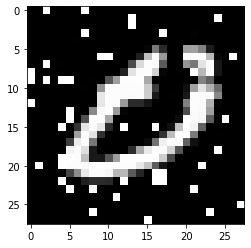

fitting gen: 0 with mean fitness value: -0.4999483525753021
adverserial class 6 for label 0 found in 13 generations!
found [6] in 3.046875 seconds


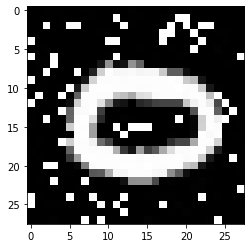

fitting gen: 0 with mean fitness value: -0.4999992549419403
adverserial class 2 for label 0 found in 9 generations!
found [2] in 2.234375 seconds


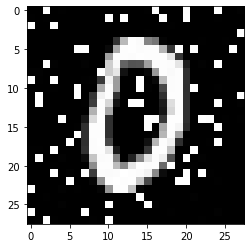

fitting gen: 0 with mean fitness value: -0.4999696910381317
adverserial class 2 for label 0 found in 6 generations!
found [2] in 1.359375 seconds


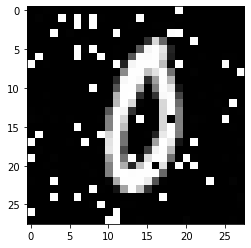

fitting gen: 0 with mean fitness value: -0.49999988079071045
adverserial class 2 for label 0 found in 13 generations!
found [2] in 2.90625 seconds


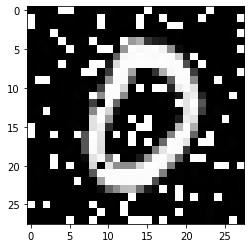

fitting gen: 0 with mean fitness value: -0.5
adverserial class 8 for label 0 found in 6 generations!
found [8] in 1.515625 seconds


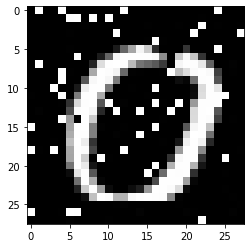

fitting gen: 0 with mean fitness value: -0.49999991059303284
adverserial class 8 for label 0 found in 22 generations!
found [8] in 4.8125 seconds


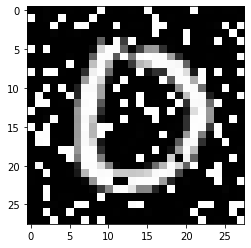

fitting gen: 0 with mean fitness value: -0.3927968442440033
adverserial class 8 for label 0 found in 1 generations!
found [8] in 0.46875 seconds


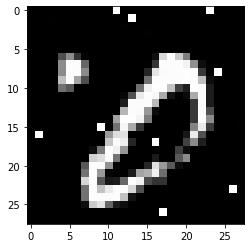

fitting gen: 0 with mean fitness value: -0.5
adverserial class 8 for label 1 found in 5 generations!
found [8] in 1.109375 seconds


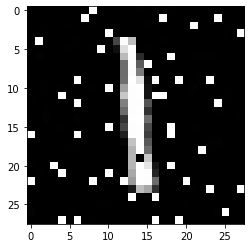

fitting gen: 0 with mean fitness value: -0.4999999701976776
adverserial class 5 for label 1 found in 5 generations!
found [5] in 1.140625 seconds


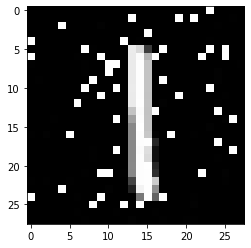

fitting gen: 0 with mean fitness value: -0.4999879002571106
adverserial class 4 for label 1 found in 2 generations!
found [4] in 0.546875 seconds


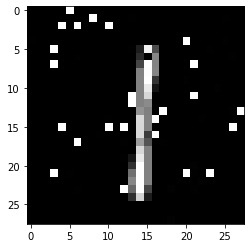

fitting gen: 0 with mean fitness value: -0.49999991059303284
adverserial class 4 for label 1 found in 6 generations!
found [4] in 1.359375 seconds


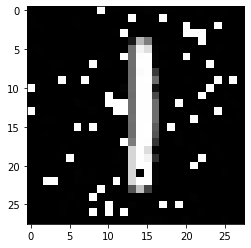

fitting gen: 0 with mean fitness value: -0.49999991059303284
adverserial class 2 for label 1 found in 4 generations!
found [2] in 0.953125 seconds


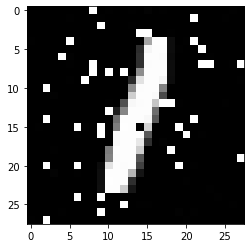

fitting gen: 0 with mean fitness value: -0.4999842345714569
adverserial class 2 for label 1 found in 3 generations!
found [2] in 0.75 seconds


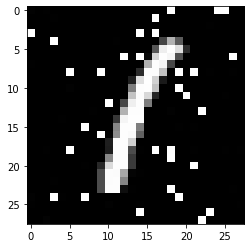

fitting gen: 0 with mean fitness value: -0.4915800094604492
adverserial class 3 for label 1 found in 1 generations!
found [3] in 0.390625 seconds


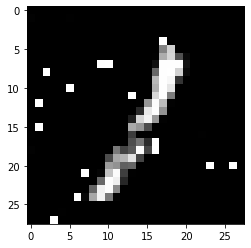

fitting gen: 0 with mean fitness value: -0.49999916553497314
adverserial class 5 for label 1 found in 3 generations!
found [5] in 0.671875 seconds


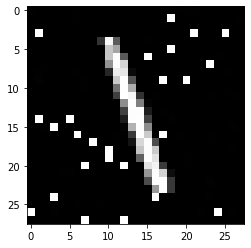

fitting gen: 0 with mean fitness value: -0.49999991059303284
adverserial class 8 for label 1 found in 3 generations!
found [8] in 0.828125 seconds


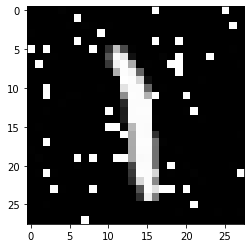

fitting gen: 0 with mean fitness value: -0.49999985098838806
adverserial class 2 for label 1 found in 5 generations!
found [2] in 1.28125 seconds


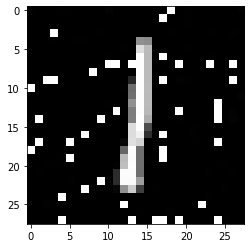

fitting gen: 0 with mean fitness value: -0.4999999701976776
adverserial class 2 for label 1 found in 5 generations!
found [2] in 1.1875 seconds


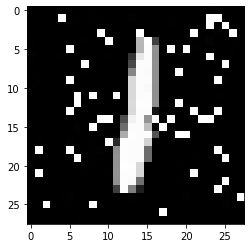

fitting gen: 0 with mean fitness value: -0.49999070167541504
adverserial class 2 for label 1 found in 2 generations!
found [2] in 0.6875 seconds


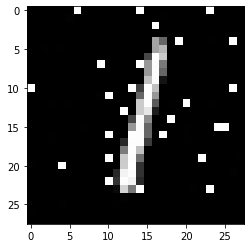

fitting gen: 0 with mean fitness value: -0.5
adverserial class 7 for label 1 found in 7 generations!
found [7] in 1.609375 seconds


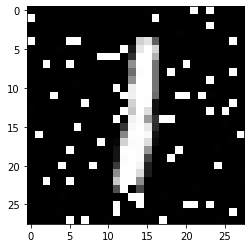

fitting gen: 0 with mean fitness value: -0.4999978244304657
adverserial class 2 for label 1 found in 2 generations!
found [2] in 0.546875 seconds


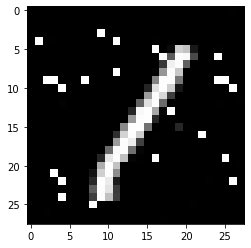

fitting gen: 0 with mean fitness value: -0.4999999701976776
adverserial class 2 for label 1 found in 3 generations!
found [2] in 0.609375 seconds


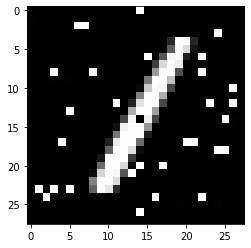

fitting gen: 0 with mean fitness value: -0.4999997913837433
adverserial class 8 for label 2 found in 42 generations!
found [8] in 9.109375 seconds


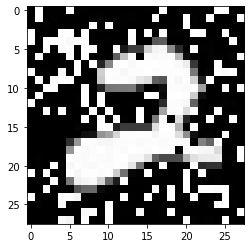

fitting gen: 0 with mean fitness value: -0.5
adverserial class 8 for label 2 found in 29 generations!
found [8] in 6.03125 seconds


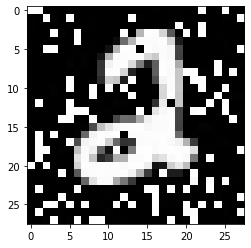

fitting gen: 0 with mean fitness value: -0.49999910593032837
adverserial class 8 for label 2 found in 26 generations!
found [8] in 5.046875 seconds


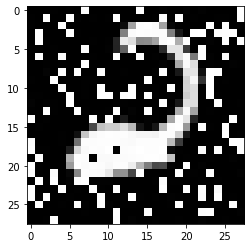

fitting gen: 0 with mean fitness value: -0.4999713599681854
adverserial class 8 for label 2 found in 10 generations!
found [8] in 2.109375 seconds


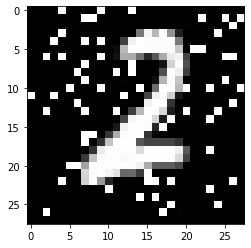

fitting gen: 0 with mean fitness value: -0.4993703067302704
adverserial class 8 for label 2 found in 5 generations!
found [8] in 0.9375 seconds


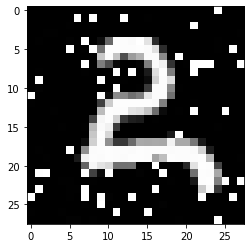

fitting gen: 0 with mean fitness value: -0.49999961256980896
adverserial class 8 for label 2 found in 10 generations!
found [8] in 1.828125 seconds


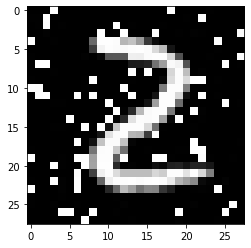

fitting gen: 0 with mean fitness value: -0.4999995529651642
adverserial class 8 for label 2 found in 12 generations!
found [8] in 2.390625 seconds


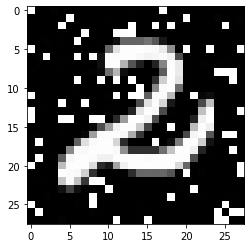

fitting gen: 0 with mean fitness value: -0.499785453081131
adverserial class 8 for label 2 found in 12 generations!
found [8] in 2.28125 seconds


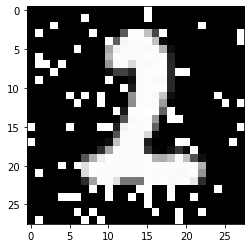

fitting gen: 0 with mean fitness value: -0.4999794363975525
adverserial class 8 for label 2 found in 11 generations!
found [8] in 1.984375 seconds


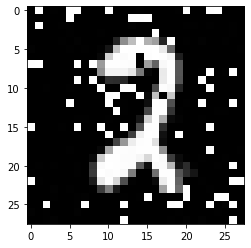

fitting gen: 0 with mean fitness value: -0.4999995529651642
adverserial class 8 for label 2 found in 14 generations!
found [8] in 2.65625 seconds


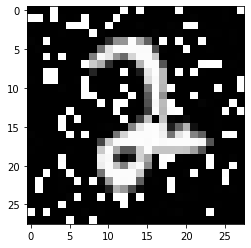

fitting gen: 0 with mean fitness value: -0.4999920725822449
adverserial class 8 for label 2 found in 17 generations!
found [8] in 3.578125 seconds


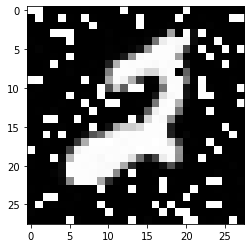

fitting gen: 0 with mean fitness value: -0.4818516969680786
adverserial class 7 for label 2 found in 4 generations!
found [7] in 1.015625 seconds


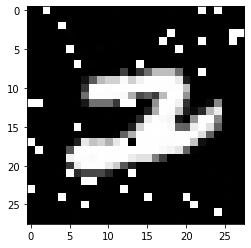

fitting gen: 0 with mean fitness value: -0.49999988079071045
adverserial class 8 for label 3 found in 4 generations!
found [8] in 0.8125 seconds


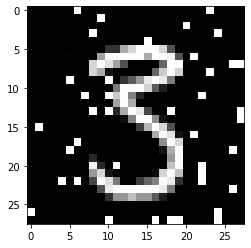

fitting gen: 0 with mean fitness value: -0.5
adverserial class 8 for label 3 found in 10 generations!
found [8] in 2.015625 seconds


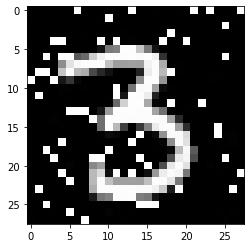

fitting gen: 0 with mean fitness value: -0.49999919533729553
adverserial class 2 for label 3 found in 7 generations!
found [2] in 1.34375 seconds


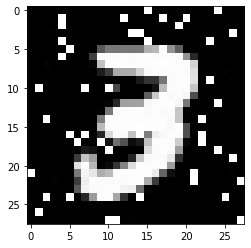

fitting gen: 0 with mean fitness value: -0.4999999701976776
adverserial class 8 for label 3 found in 7 generations!
found [8] in 1.265625 seconds


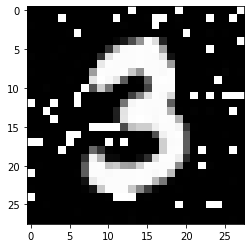

fitting gen: 0 with mean fitness value: -0.5
adverserial class 8 for label 3 found in 7 generations!
found [8] in 1.53125 seconds


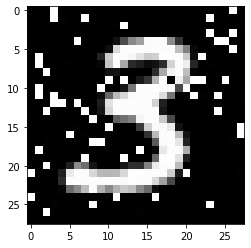

fitting gen: 0 with mean fitness value: -0.5
adverserial class 8 for label 3 found in 9 generations!
found [8] in 1.890625 seconds


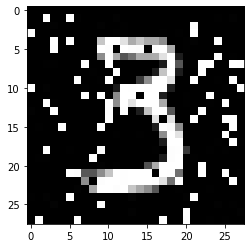

fitting gen: 0 with mean fitness value: -0.4999999701976776
adverserial class 8 for label 3 found in 12 generations!
found [8] in 2.140625 seconds


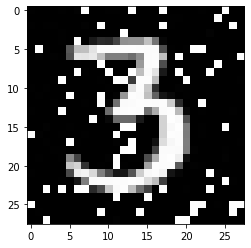

fitting gen: 0 with mean fitness value: -0.5
adverserial class 8 for label 3 found in 24 generations!
found [8] in 4.75 seconds


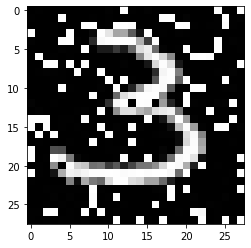

fitting gen: 0 with mean fitness value: -0.49999991059303284
adverserial class 5 for label 3 found in 6 generations!
found [5] in 1.375 seconds


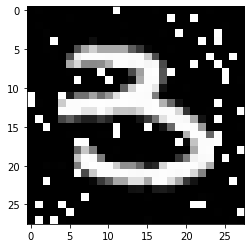

fitting gen: 0 with mean fitness value: -0.5
adverserial class 8 for label 3 found in 7 generations!
found [8] in 1.53125 seconds


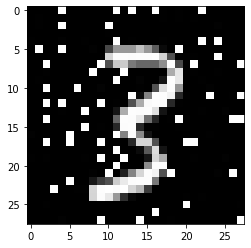

fitting gen: 0 with mean fitness value: -0.4999997317790985
adverserial class 8 for label 3 found in 8 generations!
found [8] in 1.703125 seconds


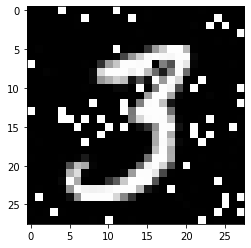

fitting gen: 0 with mean fitness value: -0.5
adverserial class 9 for label 4 found in 12 generations!
found [9] in 2.5625 seconds


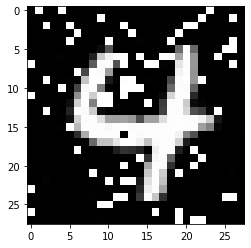

fitting gen: 0 with mean fitness value: -0.5
adverserial class 8 for label 4 found in 21 generations!
found [8] in 4.296875 seconds


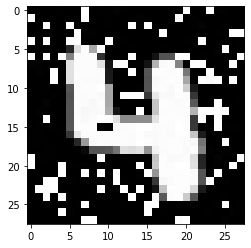

fitting gen: 0 with mean fitness value: -0.5
adverserial class 8 for label 4 found in 32 generations!
found [8] in 7.125 seconds


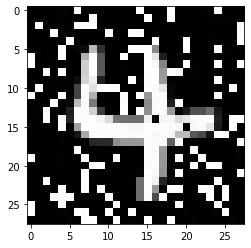

fitting gen: 0 with mean fitness value: -0.5
adverserial class 8 for label 4 found in 8 generations!
found [8] in 1.6875 seconds


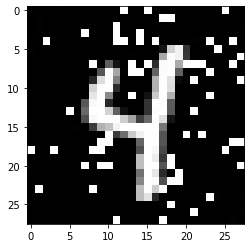

fitting gen: 0 with mean fitness value: -0.4999988377094269
adverserial class 8 for label 4 found in 9 generations!
found [8] in 1.921875 seconds


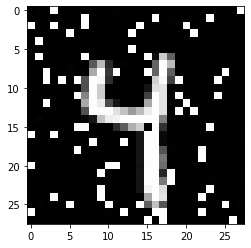

fitting gen: 0 with mean fitness value: -0.5
adverserial class 8 for label 4 found in 6 generations!
found [8] in 1.453125 seconds


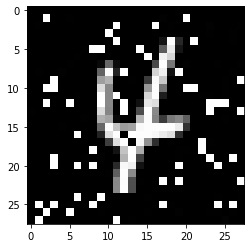

fitting gen: 0 with mean fitness value: -0.5
adverserial class 2 for label 4 found in 10 generations!
found [2] in 2.390625 seconds


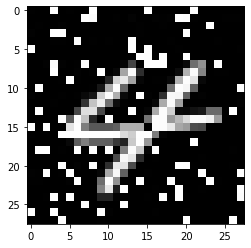

fitting gen: 0 with mean fitness value: -0.5
adverserial class 8 for label 4 found in 10 generations!
found [8] in 2.609375 seconds


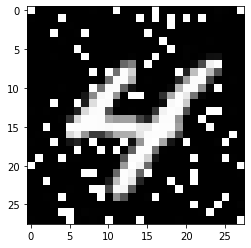

fitting gen: 0 with mean fitness value: -0.49999943375587463
adverserial class 8 for label 4 found in 6 generations!
found [8] in 1.5625 seconds


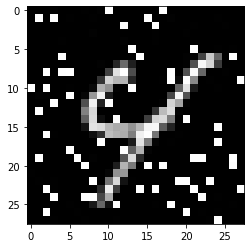

fitting gen: 0 with mean fitness value: -0.4999999701976776
adverserial class 9 for label 4 found in 13 generations!
found [9] in 2.859375 seconds


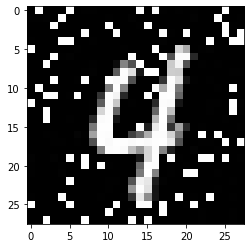

fitting gen: 0 with mean fitness value: -0.4999985694885254
adverserial class 9 for label 4 found in 6 generations!
found [9] in 1.578125 seconds


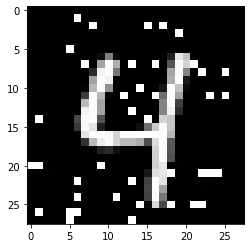

fitting gen: 0 with mean fitness value: -0.4999987483024597
adverserial class 5 for label 4 found in 5 generations!
found [5] in 1.3125 seconds


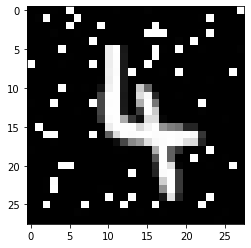

fitting gen: 0 with mean fitness value: -0.49999961256980896
adverserial class 2 for label 4 found in 4 generations!
found [2] in 1.3125 seconds


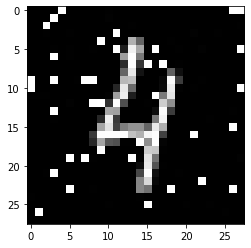

fitting gen: 0 with mean fitness value: -0.49999892711639404
adverserial class 8 for label 5 found in 4 generations!
found [8] in 1.140625 seconds


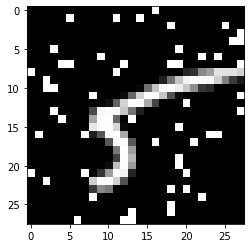

fitting gen: 0 with mean fitness value: -0.5
adverserial class 8 for label 5 found in 9 generations!
found [8] in 2.015625 seconds


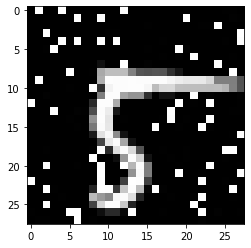

fitting gen: 0 with mean fitness value: -0.49999159574508667
adverserial class 8 for label 5 found in 3 generations!
found [8] in 0.734375 seconds


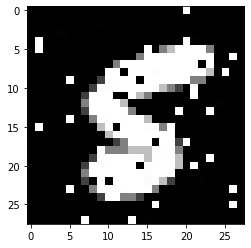

fitting gen: 0 with mean fitness value: -0.5
adverserial class 8 for label 5 found in 7 generations!
found [8] in 1.53125 seconds


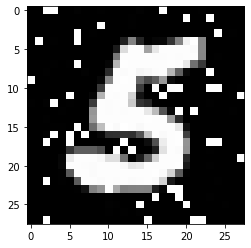

fitting gen: 0 with mean fitness value: -0.5
adverserial class 8 for label 5 found in 11 generations!
found [8] in 2.46875 seconds


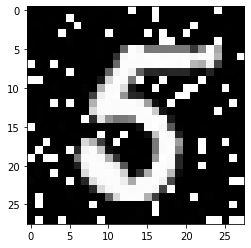

fitting gen: 0 with mean fitness value: -0.4390062987804413
adverserial class 8 for label 5 found in 1 generations!
found [8] in 0.359375 seconds


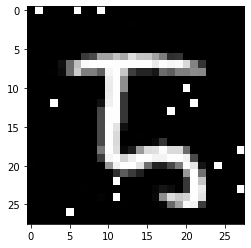

fitting gen: 0 with mean fitness value: -0.49718961119651794
adverserial class 8 for label 5 found in 2 generations!
found [8] in 0.703125 seconds


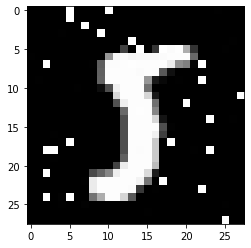

fitting gen: 0 with mean fitness value: -0.4999154508113861
adverserial class 8 for label 5 found in 3 generations!
found [8] in 0.78125 seconds


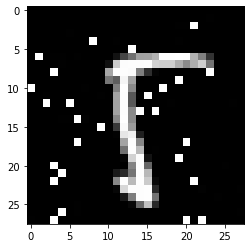

fitting gen: 0 with mean fitness value: -0.5
adverserial class 8 for label 5 found in 16 generations!
found [8] in 3.53125 seconds


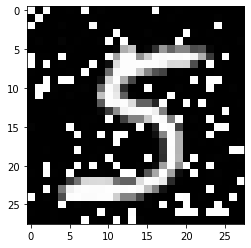

fitting gen: 0 with mean fitness value: -0.49999961256980896
adverserial class 8 for label 5 found in 6 generations!
found [8] in 1.234375 seconds


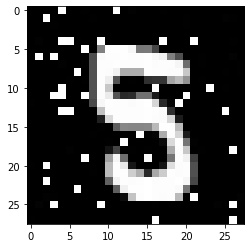

fitting gen: 0 with mean fitness value: -0.4953153729438782
adverserial class 4 for label 5 found in 3 generations!
found [4] in 0.671875 seconds


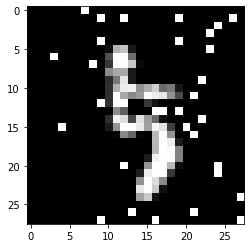

fitting gen: 0 with mean fitness value: -0.49994927644729614
adverserial class 8 for label 5 found in 6 generations!
found [8] in 1.4375 seconds


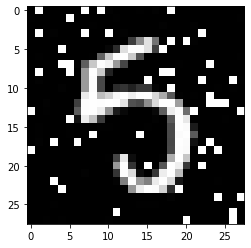

fitting gen: 0 with mean fitness value: -0.4864540696144104
adverserial class 0 for label 6 found in 2 generations!
found [0] in 0.453125 seconds


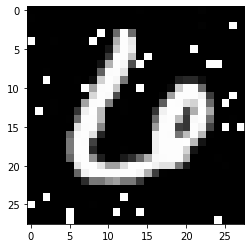

fitting gen: 0 with mean fitness value: -0.5
adverserial class 8 for label 6 found in 16 generations!
found [8] in 3.6875 seconds


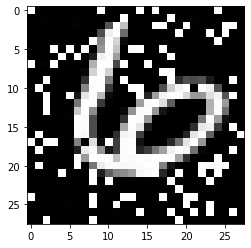

fitting gen: 0 with mean fitness value: -0.49999791383743286
adverserial class 4 for label 6 found in 11 generations!
found [4] in 2.5625 seconds


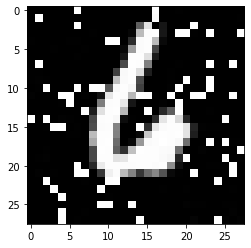

fitting gen: 0 with mean fitness value: -0.4699951708316803
adverserial class 5 for label 6 found in 3 generations!
found [5] in 0.875 seconds


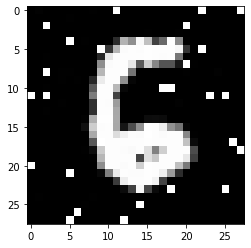

fitting gen: 0 with mean fitness value: -0.5
adverserial class 8 for label 6 found in 9 generations!
found [8] in 2.65625 seconds


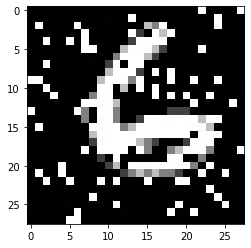

fitting gen: 0 with mean fitness value: -0.49999767541885376
adverserial class 0 for label 6 found in 9 generations!
found [0] in 1.953125 seconds


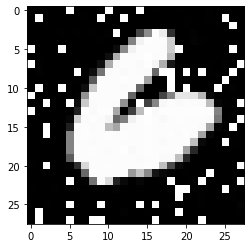

fitting gen: 0 with mean fitness value: -0.49999600648880005
adverserial class 2 for label 6 found in 4 generations!
found [2] in 0.828125 seconds


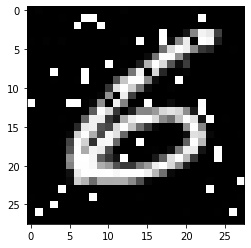

fitting gen: 0 with mean fitness value: -0.4999973475933075
adverserial class 8 for label 6 found in 3 generations!
found [8] in 0.875 seconds


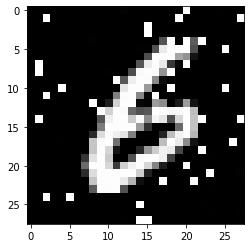

fitting gen: 0 with mean fitness value: -0.5
adverserial class 2 for label 6 found in 7 generations!
found [2] in 1.75 seconds


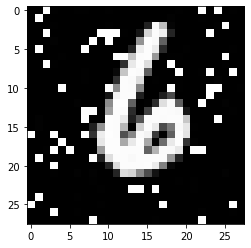

fitting gen: 0 with mean fitness value: -0.499288409948349
adverserial class 5 for label 6 found in 3 generations!
found [5] in 0.8125 seconds


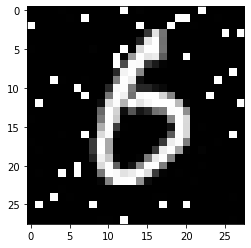

fitting gen: 0 with mean fitness value: -0.4999995529651642
adverserial class 8 for label 6 found in 10 generations!
found [8] in 2.09375 seconds


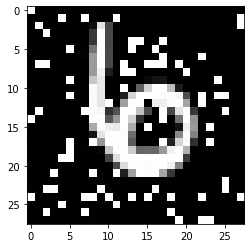

fitting gen: 0 with mean fitness value: -0.4999443292617798
adverserial class 5 for label 6 found in 5 generations!
found [5] in 1.046875 seconds


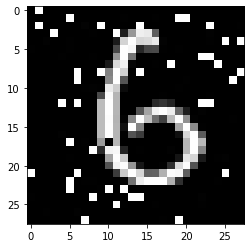

adverserial class 9 for label 7 found in 0 generations!
found [9] in 0.171875 seconds


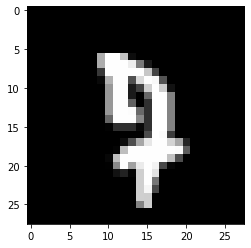

fitting gen: 0 with mean fitness value: -0.4975777566432953
adverserial class 2 for label 7 found in 2 generations!
found [2] in 0.578125 seconds


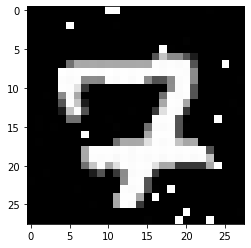

fitting gen: 0 with mean fitness value: -0.49999937415122986
adverserial class 2 for label 7 found in 6 generations!
found [2] in 1.359375 seconds


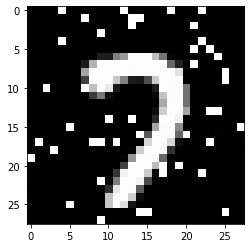

fitting gen: 0 with mean fitness value: -0.5
adverserial class 5 for label 7 found in 13 generations!
found [5] in 2.671875 seconds


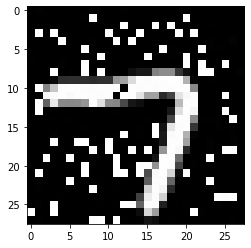

fitting gen: 0 with mean fitness value: -0.4999999701976776
adverserial class 9 for label 7 found in 14 generations!
found [9] in 2.921875 seconds


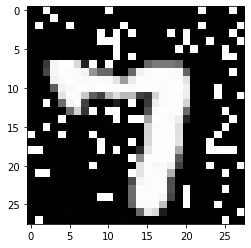

fitting gen: 0 with mean fitness value: -0.19564494490623474
adverserial class 9 for label 7 found in 1 generations!
found [9] in 0.359375 seconds


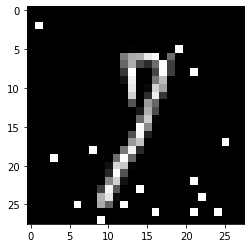

fitting gen: 0 with mean fitness value: -0.4999977648258209
adverserial class 2 for label 7 found in 4 generations!
found [2] in 0.921875 seconds


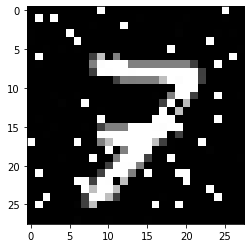

fitting gen: 0 with mean fitness value: -0.4999963939189911
adverserial class 2 for label 7 found in 8 generations!
found [2] in 1.71875 seconds


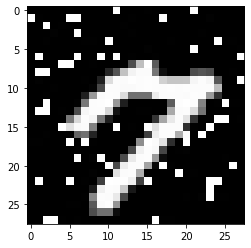

fitting gen: 0 with mean fitness value: -0.4999978244304657
adverserial class 2 for label 7 found in 5 generations!
found [2] in 1.109375 seconds


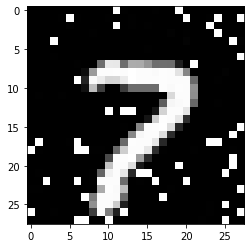

fitting gen: 0 with mean fitness value: -0.49999889731407166
adverserial class 2 for label 7 found in 5 generations!
found [2] in 1.078125 seconds


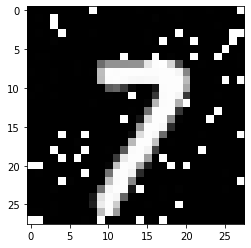

fitting gen: 0 with mean fitness value: -0.4999706447124481
adverserial class 2 for label 7 found in 5 generations!
found [2] in 0.921875 seconds


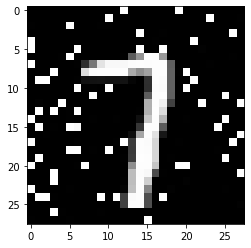

fitting gen: 0 with mean fitness value: -0.4999993145465851
adverserial class 2 for label 7 found in 6 generations!
found [2] in 1.421875 seconds


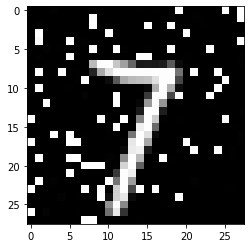

fitting gen: 0 with mean fitness value: -0.49999377131462097
adverserial class 2 for label 7 found in 4 generations!
found [2] in 0.9375 seconds


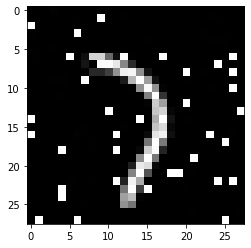

fitting gen: 0 with mean fitness value: -0.49999111890792847
adverserial class 2 for label 8 found in 171 generations!
found [2] in 34.34375 seconds


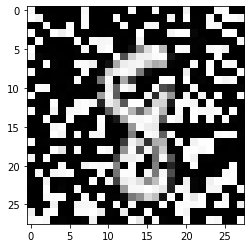

fitting gen: 0 with mean fitness value: -0.4999983310699463
adverserial class 2 for label 8 found in 75 generations!
found [2] in 16.328125 seconds


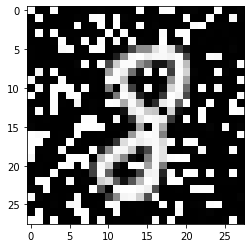

fitting gen: 0 with mean fitness value: -0.5
adverserial class 2 for label 8 found in 48 generations!
found [2] in 9.453125 seconds


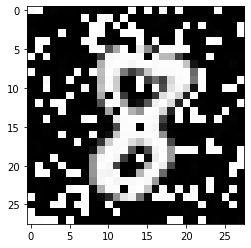

fitting gen: 0 with mean fitness value: -0.5
fitting gen: 250 with mean fitness value: -3.4869270534249375
adverserial class 2 for label 8 found in 326 generations!
found [2] in 59.828125 seconds


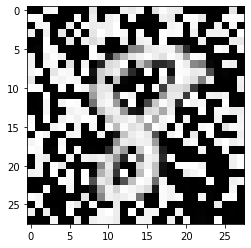

fitting gen: 0 with mean fitness value: -0.49999988079071045
fitting gen: 250 with mean fitness value: -3.5052008227100724
fitting gen: 500 with mean fitness value: -3.715570964287252
fitting gen: 750 with mean fitness value: -3.707256971023067
fitting gen: 1000 with mean fitness value: -3.619378959265051
adverserial class 2 for label 8 found in 1067 generations!
found [2] in 199.171875 seconds


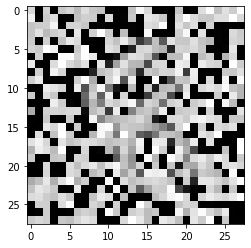

fitting gen: 0 with mean fitness value: -0.5
fitting gen: 250 with mean fitness value: -3.5251503477042565
fitting gen: 500 with mean fitness value: -3.6930937460595015
fitting gen: 750 with mean fitness value: -3.6870968006668146
fitting gen: 1000 with mean fitness value: -3.6142226852112156
adverserial class 2 for label 8 found in 1114 generations!
found [2] in 223.375 seconds


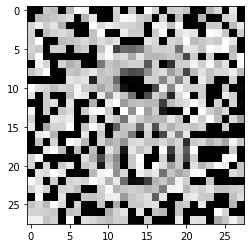

fitting gen: 0 with mean fitness value: -0.5
adverserial class 2 for label 8 found in 154 generations!
found [2] in 26.6875 seconds


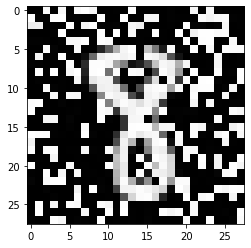

fitting gen: 0 with mean fitness value: -0.4994714856147766
adverserial class 2 for label 8 found in 1 generations!
found [2] in 0.28125 seconds


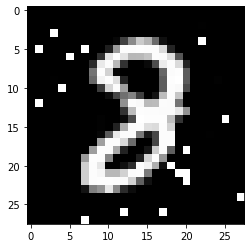

fitting gen: 0 with mean fitness value: -0.4999907314777374
fitting gen: 250 with mean fitness value: -3.624175221389543
fitting gen: 500 with mean fitness value: -3.7845078785038697
fitting gen: 750 with mean fitness value: -3.777857908632932
fitting gen: 1000 with mean fitness value: -3.680851449878132
adverserial class 2 for label 8 found in 1120 generations!
found [2] in 212.265625 seconds


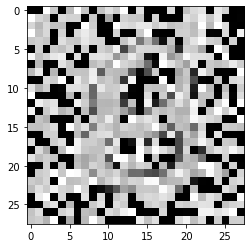

fitting gen: 0 with mean fitness value: -0.49999991059303284
adverserial class 2 for label 8 found in 12 generations!
found [2] in 2.34375 seconds


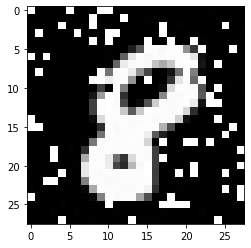

fitting gen: 0 with mean fitness value: -0.5
adverserial class 2 for label 8 found in 30 generations!
found [2] in 5.515625 seconds


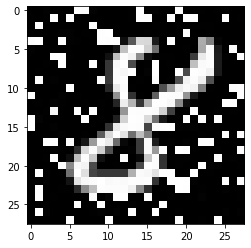

fitting gen: 0 with mean fitness value: -0.5
adverserial class 2 for label 8 found in 25 generations!
found [2] in 4.765625 seconds


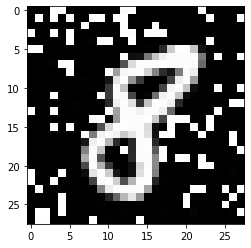

fitting gen: 0 with mean fitness value: -0.49999284744262695
adverserial class 4 for label 9 found in 4 generations!
found [4] in 1.0 seconds


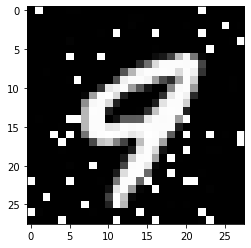

fitting gen: 0 with mean fitness value: -0.4999997317790985
adverserial class 8 for label 9 found in 9 generations!
found [8] in 1.8125 seconds


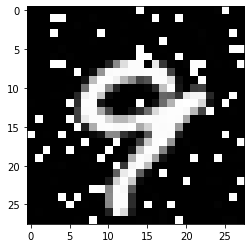

fitting gen: 0 with mean fitness value: -0.49995124340057373
adverserial class 7 for label 9 found in 3 generations!
found [7] in 0.921875 seconds


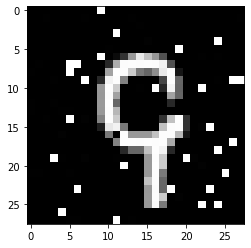

fitting gen: 0 with mean fitness value: -0.49999991059303284
adverserial class 8 for label 9 found in 7 generations!
found [8] in 1.46875 seconds


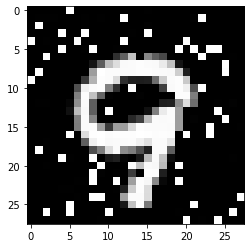

fitting gen: 0 with mean fitness value: -0.4999687075614929
adverserial class 4 for label 9 found in 3 generations!
found [4] in 0.546875 seconds


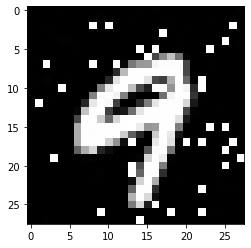

fitting gen: 0 with mean fitness value: -0.4999992549419403
adverserial class 8 for label 9 found in 4 generations!
found [8] in 0.9375 seconds


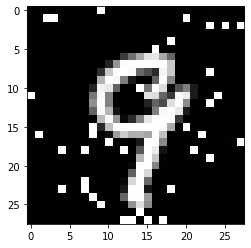

fitting gen: 0 with mean fitness value: -0.4999958574771881
adverserial class 4 for label 9 found in 2 generations!
found [4] in 0.625 seconds


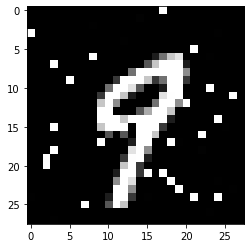

fitting gen: 0 with mean fitness value: -0.499980092048645
adverserial class 4 for label 9 found in 3 generations!
found [4] in 0.78125 seconds


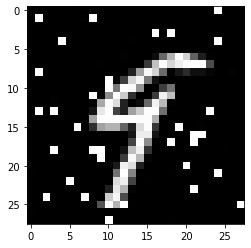

fitting gen: 0 with mean fitness value: -0.5
adverserial class 8 for label 9 found in 15 generations!
found [8] in 2.96875 seconds


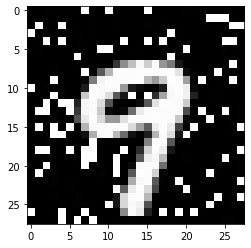

fitting gen: 0 with mean fitness value: -0.49997246265411377
adverserial class 8 for label 9 found in 6 generations!
found [8] in 1.03125 seconds


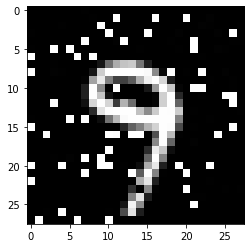

fitting gen: 0 with mean fitness value: -0.49999746680259705
adverserial class 8 for label 9 found in 5 generations!
found [8] in 1.09375 seconds


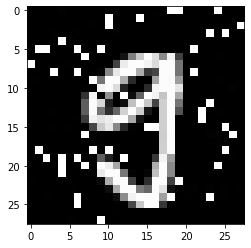

fitting gen: 0 with mean fitness value: -0.4999925196170807
adverserial class 8 for label 9 found in 9 generations!
found [8] in 1.703125 seconds


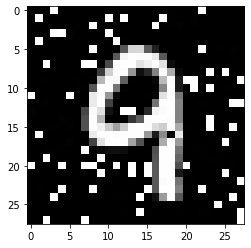

fitting gen: 0 with mean fitness value: -0.4999903738498688
adverserial class 4 for label 9 found in 6 generations!
found [4] in 1.171875 seconds


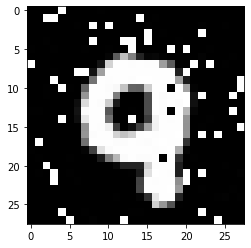

In [14]:
times = []
nfes = []
psnrs = []
predicted_classes = []
adversarials = []
ssim_scores = []

for i, (im, lbl) in enumerate(zip(adversarial, adversarial_y)):
    start = time.process_time()
    CURRENT_IM  = im
    CURRENT_LABEL = lbl
    
    def gen_ind():
        return adversarial[i]
    
    def calculate_fitness(ind, l1=0.5, l2=0.5): 
        # this is indredibly stupid but had do be done to combine our setup wit DEAP...
        
        target_image = CURRENT_IM
        label = CURRENT_LABEL
        predictions = model.predict(ind.reshape(1,MNIST_IMG,MNIST_IMG,1) / 255.0)  

        # po is the ground truth prediction, so for label = 0, it will be prediciton[0]
        predictions = predictions[0]
        po = predictions[label]

        # set that value to 0
        predictions[label]=0

        # take next highest one
        pd = np.max(predictions)
        diff=pd-po
        a = l1*euclidean(ind-target_image)/LEN
        return (-a+l2*(diff)),
    
    # encode strategy
    creator.create("FitnessMax", base.Fitness, weights=(1.0,))
    creator.create("Individual", np.ndarray, typecode="d", fitness=creator.FitnessMax, strategy=None)
    creator.create("Strategy", np.ndarray, typecode="d")


    # create population
    tbx = base.Toolbox()
    tbx.register("individual", 
                 tools.initRepeat, 
                 creator.Individual,
                 gen_ind,
                 n=1)
    tbx.register("population", tools.initRepeat, list, tbx.individual)

# parameters
    tbx.register("evaluate", calculate_fitness)
    tbx.register("mate", tools.cxUniform, indpb=P_CROSS) #tools.cxTwoPoint, tools.cxUniform
    tbx.register("mutate", tools.mutGaussian, mu=0, sigma=1, indpb=P_MUTATION)
    tbx.register("select", tools.selTournament, tournsize=3)
    
    example, generations = main(im, lbl)
    
    adversarials.append(example)
    nfes.append(generations)
    predicted_classes.append(model.predict(example.reshape(1, 28,28,1)/255.))
    ssim_scores.append(computing_SSIM(example, CURRENT_IM))
    psnrs.append(cv2.PSNR(CURRENT_IM.reshape(28,28), example.reshape(28,28)))
    times.append(time.process_time() - start)
    
    print(f'found {np.argmax(model.predict(example.reshape(1, 28,28,1)/255.), axis=1)} in {time.process_time() - start} seconds')
    plt.imshow(example.reshape(28,28), cmap="gray")
    plt.show()

In [15]:
file_ = open('adv_cnn_1_un', 'wb')
adversarials = [np.array(x) for x in adversarials]
pickle.dump(adversarials, file_)
pickle.dump(times, file_)
pickle.dump(nfes , file_)
pickle.dump(psnrs , file_)
pickle.dump(ssim_scores, file_)
pickle.dump(predicted_classes, file_)
file_.close()

PSNR for image 0: 361.20199909921956


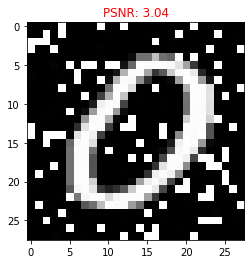

PSNR for image 1: 361.20199909921956


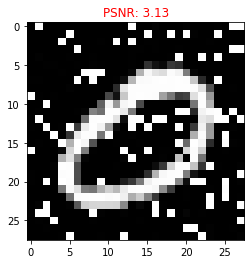

PSNR for image 2: 361.20199909921956


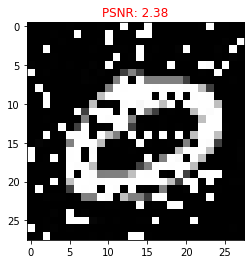

PSNR for image 3: 361.20199909921956


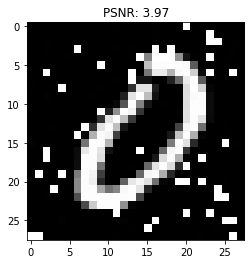

PSNR for image 4: 361.20199909921956


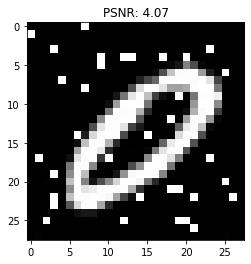

PSNR for image 5: 361.20199909921956


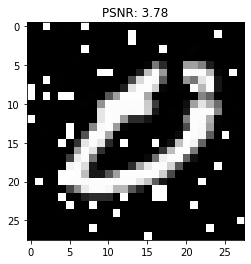

PSNR for image 6: 361.20199909921956


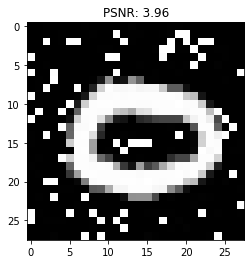

PSNR for image 7: 361.20199909921956


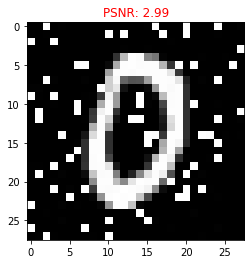

PSNR for image 8: 361.20199909921956


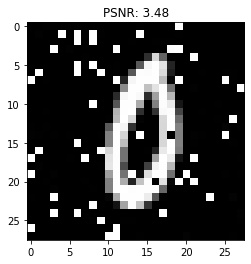

PSNR for image 9: 361.20199909921956


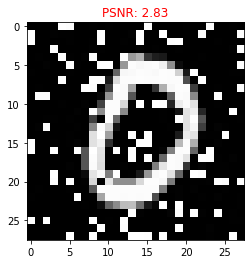

PSNR for image 10: 361.20199909921956


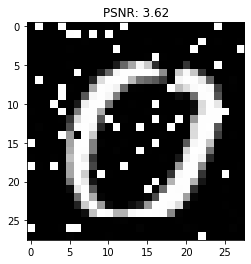

PSNR for image 11: 361.20199909921956


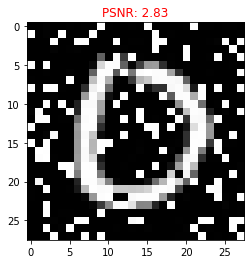

PSNR for image 12: 361.20199909921956


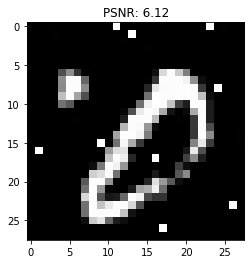

PSNR for image 13: 361.20199909921956


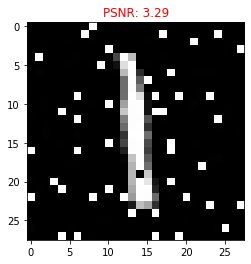

PSNR for image 14: 361.20199909921956


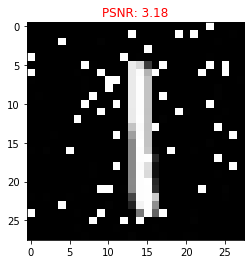

PSNR for image 15: 361.20199909921956


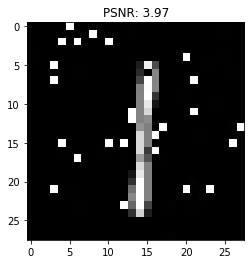

PSNR for image 16: 361.20199909921956


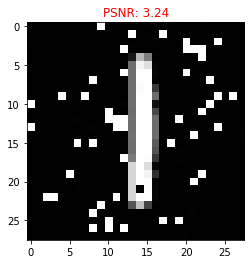

PSNR for image 17: 361.20199909921956


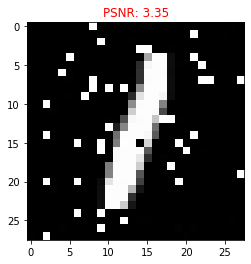

PSNR for image 18: 361.20199909921956


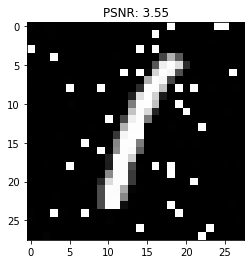

PSNR for image 19: 361.20199909921956


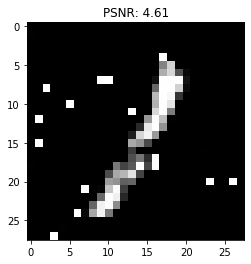

PSNR for image 20: 361.20199909921956


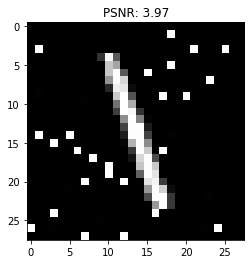

PSNR for image 21: 361.20199909921956


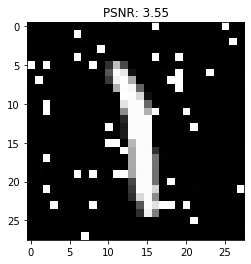

PSNR for image 22: 361.20199909921956


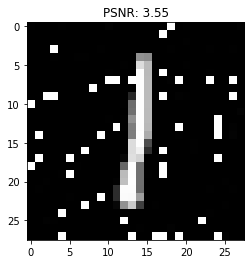

PSNR for image 23: 361.20199909921956


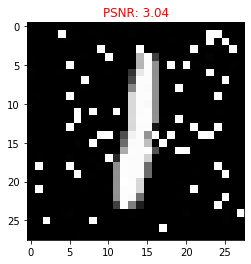

PSNR for image 24: 361.20199909921956


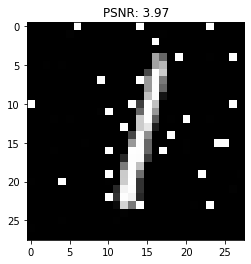

PSNR for image 25: 361.20199909921956


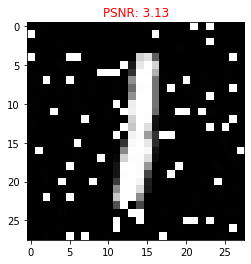

PSNR for image 26: 361.20199909921956


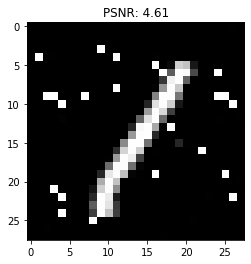

PSNR for image 27: 361.20199909921956


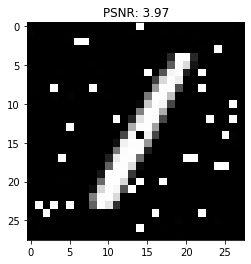

PSNR for image 28: 361.20199909921956


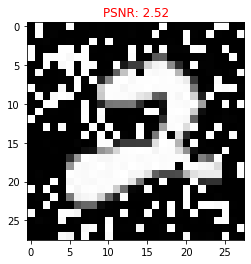

PSNR for image 29: 361.20199909921956


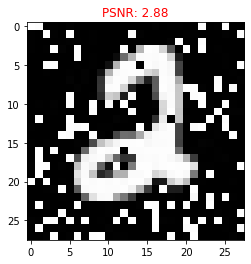

PSNR for image 30: 361.20199909921956


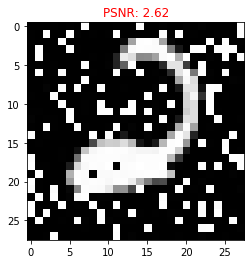

PSNR for image 31: 361.20199909921956


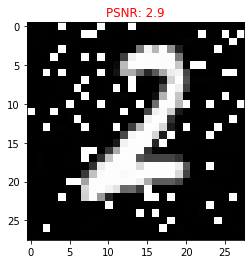

PSNR for image 32: 361.20199909921956


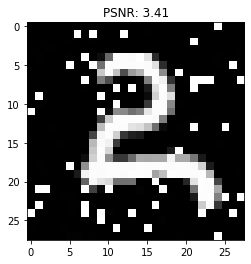

PSNR for image 33: 361.20199909921956


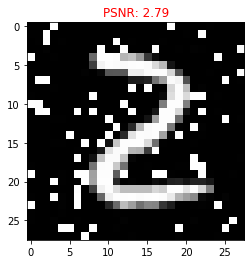

PSNR for image 34: 361.20199909921956


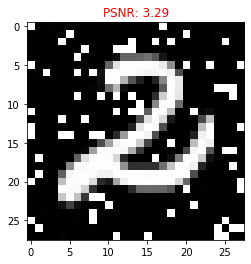

PSNR for image 35: 361.20199909921956


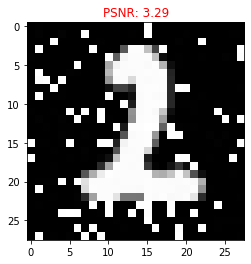

PSNR for image 36: 361.20199909921956


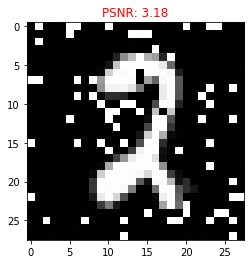

PSNR for image 37: 361.20199909921956


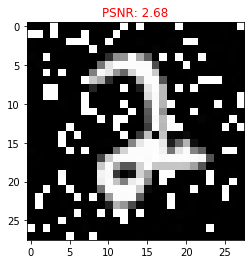

PSNR for image 38: 361.20199909921956


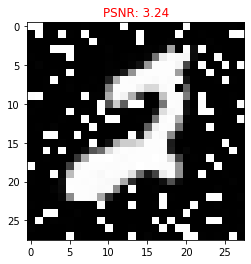

PSNR for image 39: 361.20199909921956


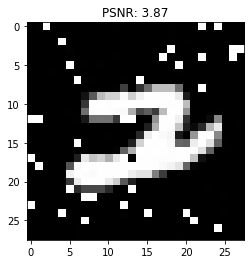

PSNR for image 40: 361.20199909921956


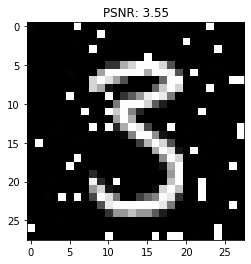

PSNR for image 41: 361.20199909921956


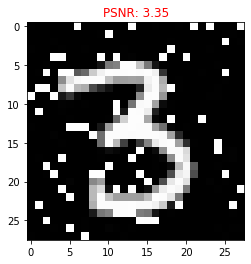

PSNR for image 42: 361.20199909921956


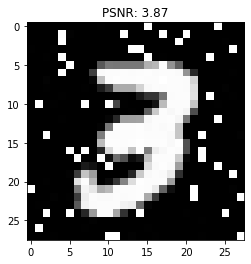

PSNR for image 43: 361.20199909921956


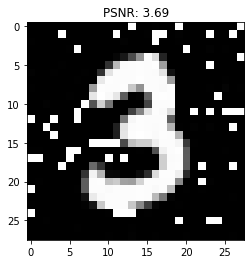

PSNR for image 44: 361.20199909921956


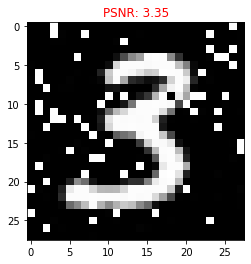

PSNR for image 45: 361.20199909921956


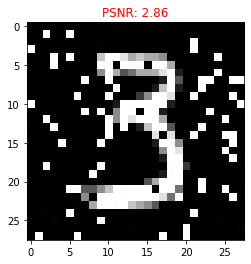

PSNR for image 46: 361.20199909921956


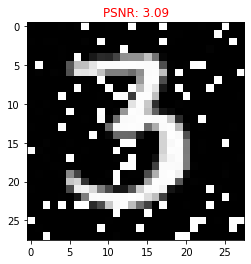

PSNR for image 47: 361.20199909921956


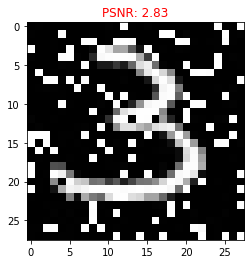

PSNR for image 48: 361.20199909921956


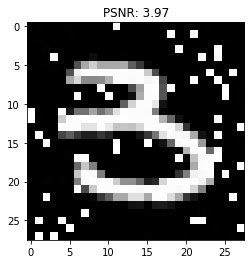

PSNR for image 49: 361.20199909921956


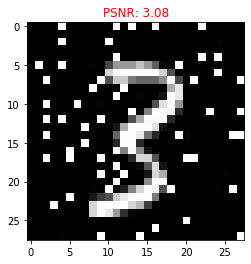

PSNR for image 50: 361.20199909921956


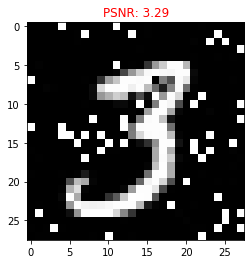

PSNR for image 51: 361.20199909921956


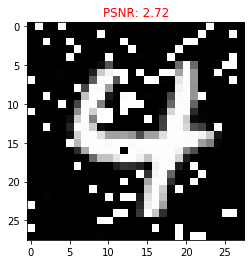

PSNR for image 52: 361.20199909921956


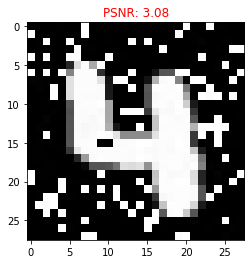

PSNR for image 53: 361.20199909921956


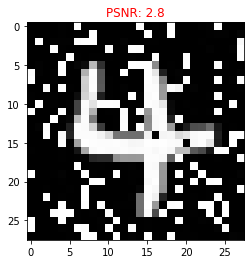

PSNR for image 54: 361.20199909921956


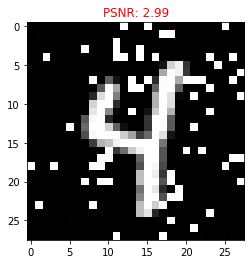

PSNR for image 55: 361.20199909921956


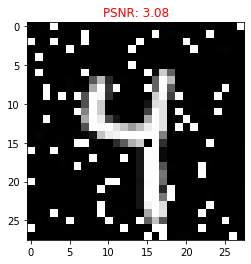

PSNR for image 56: 361.20199909921956


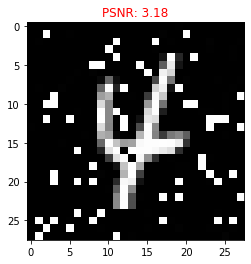

PSNR for image 57: 361.20199909921956


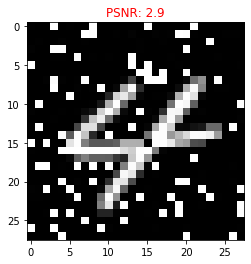

PSNR for image 58: 361.20199909921956


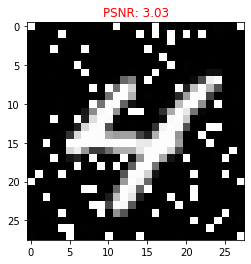

PSNR for image 59: 361.20199909921956


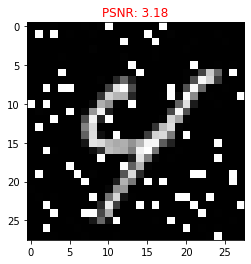

PSNR for image 60: 361.20199909921956


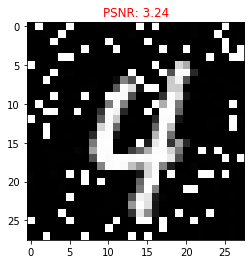

PSNR for image 61: 361.20199909921956


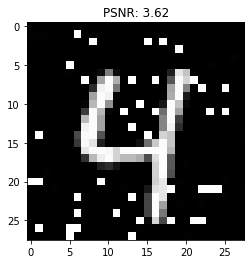

PSNR for image 62: 361.20199909921956


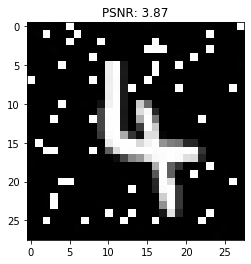

PSNR for image 63: 361.20199909921956


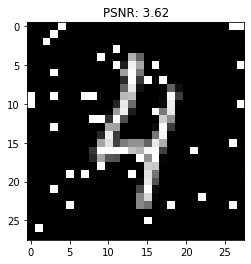

PSNR for image 64: 361.20199909921956


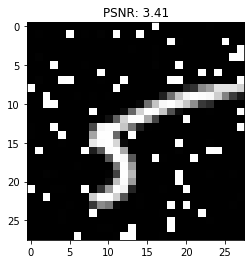

PSNR for image 65: 361.20199909921956


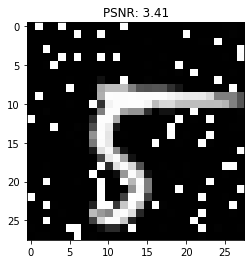

PSNR for image 66: 361.20199909921956


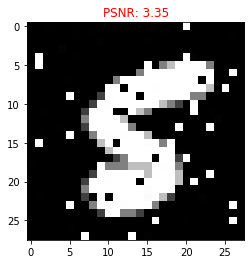

PSNR for image 67: 361.20199909921956


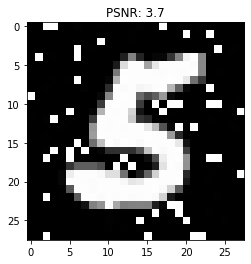

PSNR for image 68: 361.20199909921956


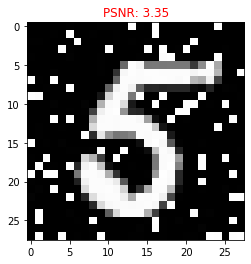

PSNR for image 69: 361.20199909921956


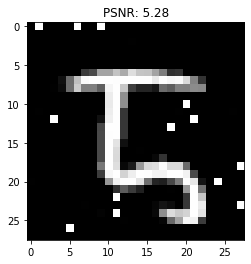

PSNR for image 70: 361.20199909921956


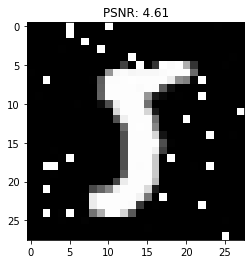

PSNR for image 71: 361.20199909921956


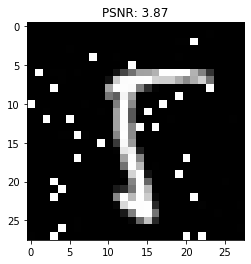

PSNR for image 72: 361.20199909921956


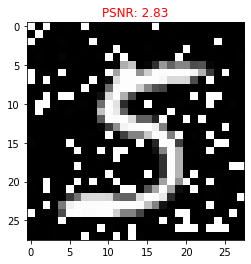

PSNR for image 73: 361.20199909921956


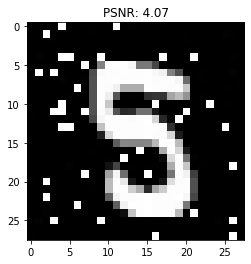

PSNR for image 74: 361.20199909921956


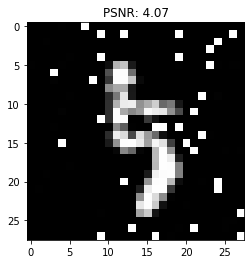

PSNR for image 75: 361.20199909921956


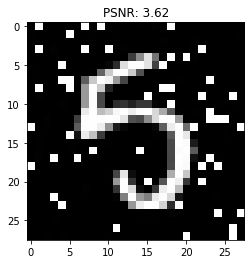

PSNR for image 76: 361.20199909921956


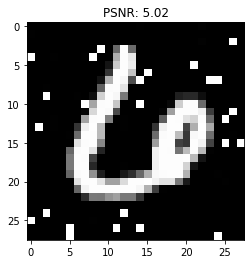

PSNR for image 77: 361.20199909921956


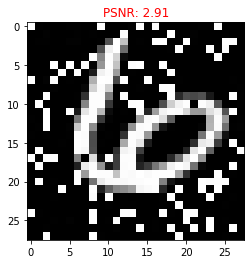

PSNR for image 78: 361.20199909921956


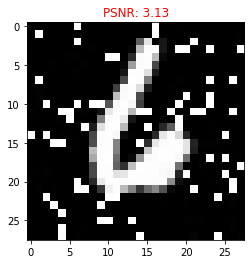

PSNR for image 79: 361.20199909921956


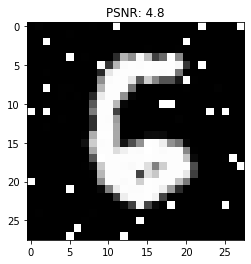

PSNR for image 80: 361.20199909921956


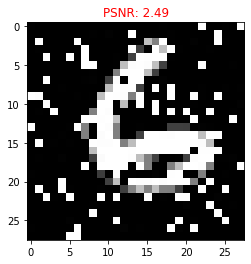

PSNR for image 81: 361.20199909921956


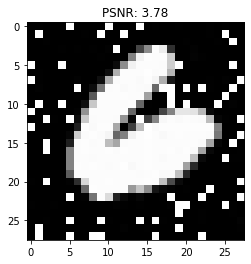

PSNR for image 82: 361.20199909921956


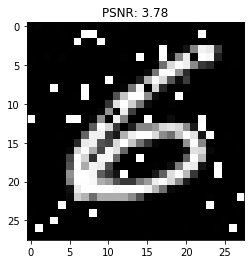

PSNR for image 83: 361.20199909921956


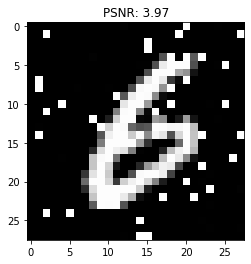

PSNR for image 84: 361.20199909921956


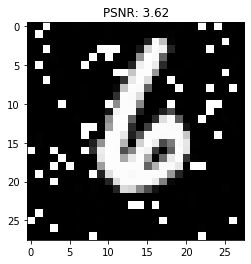

PSNR for image 85: 361.20199909921956


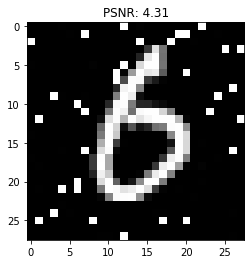

PSNR for image 86: 361.20199909921956


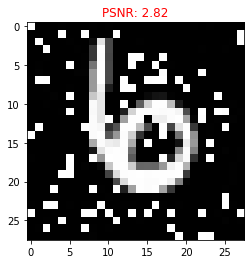

PSNR for image 87: 361.20199909921956


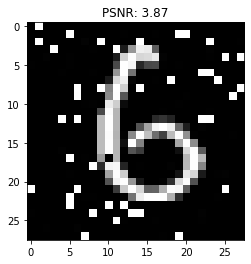

PSNR for image 88: 361.20199909921956


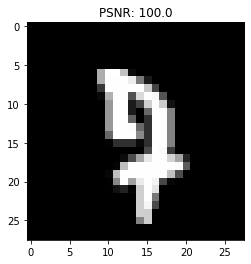

PSNR for image 89: 361.20199909921956


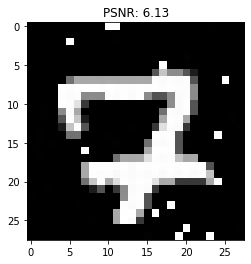

PSNR for image 90: 361.20199909921956


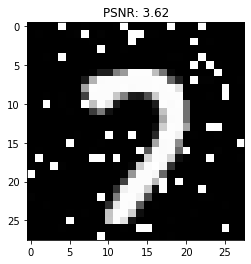

PSNR for image 91: 361.20199909921956


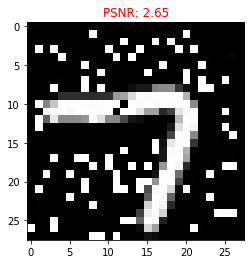

PSNR for image 92: 361.20199909921956


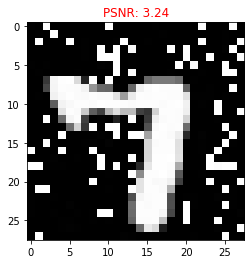

PSNR for image 93: 361.20199909921956


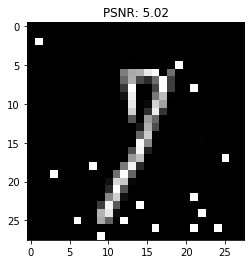

PSNR for image 94: 361.20199909921956


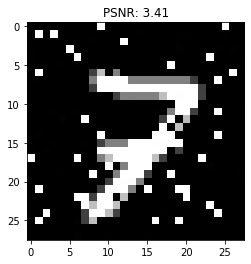

PSNR for image 95: 361.20199909921956


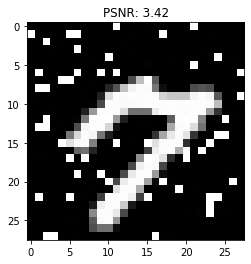

PSNR for image 96: 361.20199909921956


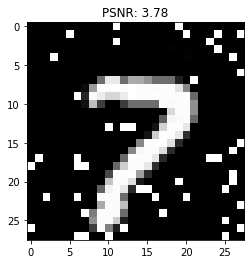

PSNR for image 97: 361.20199909921956


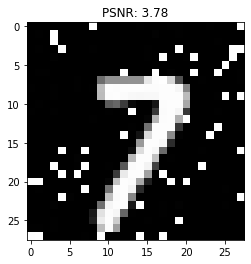

PSNR for image 98: 361.20199909921956


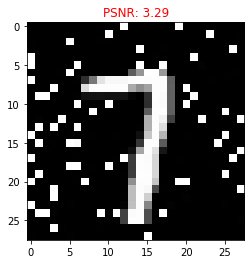

PSNR for image 99: 361.20199909921956


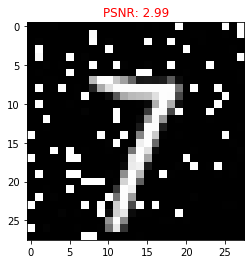

PSNR for image 100: 361.20199909921956


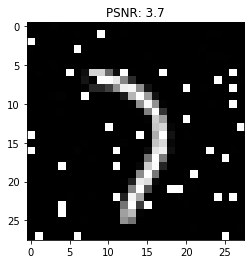

PSNR for image 101: 361.20199909921956


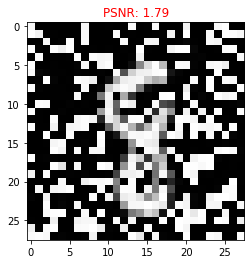

PSNR for image 102: 361.20199909921956


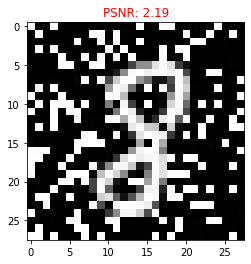

PSNR for image 103: 361.20199909921956


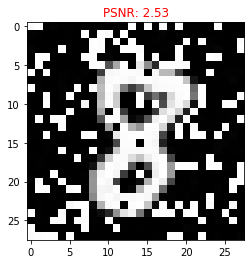

PSNR for image 104: 361.20199909921956


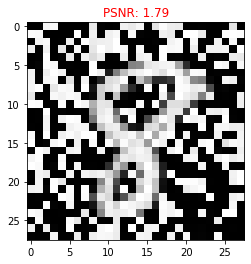

PSNR for image 105: 361.20199909921956


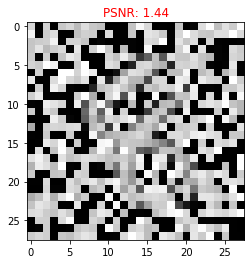

PSNR for image 106: 361.20199909921956


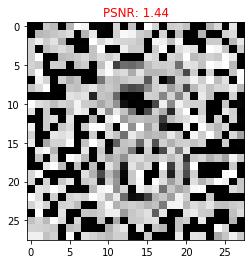

PSNR for image 107: 361.20199909921956


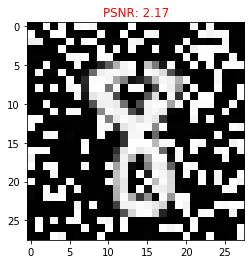

PSNR for image 108: 361.20199909921956


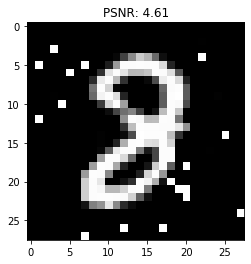

PSNR for image 109: 361.20199909921956


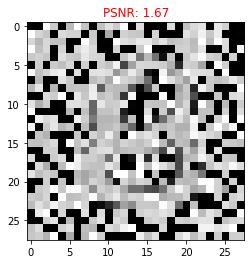

PSNR for image 110: 361.20199909921956


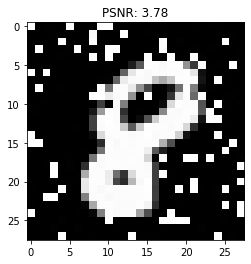

PSNR for image 111: 361.20199909921956


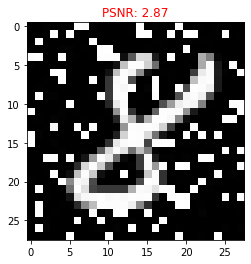

PSNR for image 112: 361.20199909921956


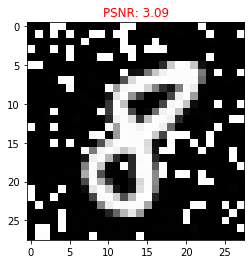

PSNR for image 113: 361.20199909921956


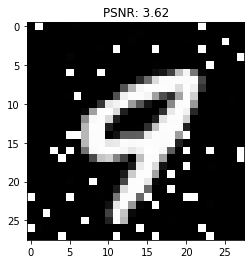

PSNR for image 114: 361.20199909921956


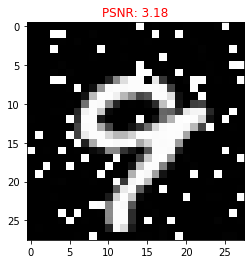

PSNR for image 115: 361.20199909921956


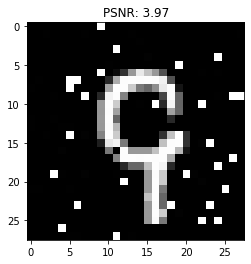

PSNR for image 116: 361.20199909921956


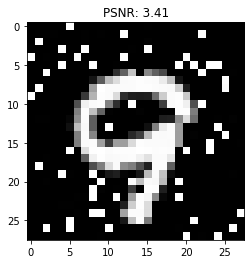

PSNR for image 117: 361.20199909921956


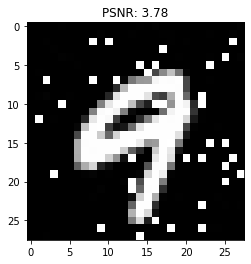

PSNR for image 118: 361.20199909921956


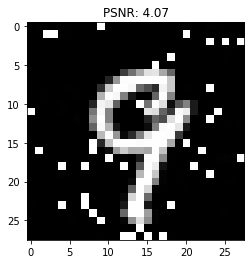

PSNR for image 119: 361.20199909921956


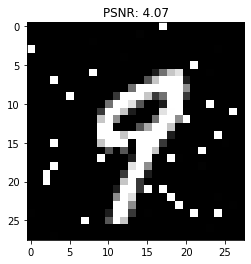

PSNR for image 120: 361.20199909921956


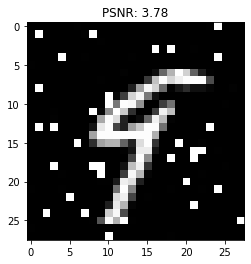

PSNR for image 121: 361.20199909921956


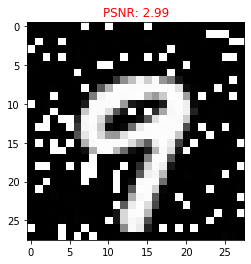

PSNR for image 122: 361.20199909921956


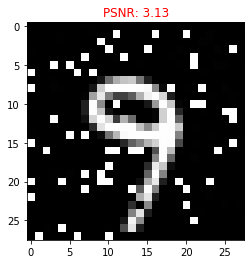

PSNR for image 123: 361.20199909921956


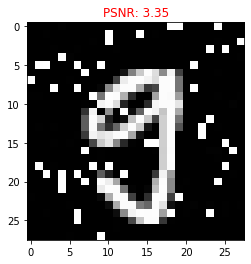

PSNR for image 124: 361.20199909921956


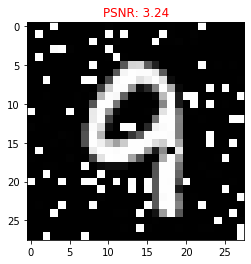

PSNR for image 125: 361.20199909921956


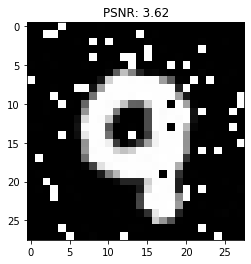

61


In [16]:
psnrs_cnn = []
for i in range(len(adversarials)):
    psnrs_cnn.append(cv2.PSNR(adversarial[i].reshape(28,28)[5:-5,5:-5], adversarials[i].reshape(28,28)[5:-5,5:-5]))

above_tresh = 0
threshold_psnr = 3.4
for i in range(len(adversarials)):
    psnr_ = cv2.PSNR(adversarial[i].reshape(28,28),adversarial[i].reshape(28,28))
    psnr_cnn = round((psnrs_cnn[i]/psnr_)*100,2)
    print("PSNR for image " + str(i) + ": " + str(psnr_))
    fig = plt.figure()
    ax1 = fig.add_subplot(1,1,1)
    ax1.imshow(adversarials[i].reshape(28,28),cmap="gray")
    if psnr_cnn < threshold_psnr:
        ax1.set_title("PSNR: "+str(psnr_cnn), color='red')
    else: 
        ax1.set_title("PSNR: "+str(psnr_cnn))
        above_tresh += 1
    plt.show()
print(above_tresh)

In [17]:
print(np.max(times))
print(np.min(times))
print(np.mean(times))
print(np.std(times))
print(np.mean(times),'+-', np.std(times),'(',np.min(times),',',np.max(times),')')

223.375
0.15625
7.910342261904762
32.51321895312724
7.910342261904762 +- 32.51321895312724 ( 0.15625 , 223.375 )


In [18]:
print(np.max(nfes))
print(np.min(nfes))
print(np.mean(nfes))
print(np.std(nfes))
print(np.mean(nfes),'+-', np.std(nfes),'(',np.min(nfes),',',np.max(nfes),')')

1120
0
40.19047619047619
169.30327415456497
40.19047619047619 +- 169.30327415456497 ( 0 , 1120 )


In [19]:
print(np.max(psnrs))
print(np.min(psnrs))
print(np.mean(psnrs))
print(np.std(psnrs))
print(np.mean(psnrs),'+-', np.std(psnrs),'(',np.min(psnrs),',',np.max(psnrs),')')

361.20199909921956
4.228336165874614
14.345941984270178
31.135772444794476
14.345941984270178 +- 31.135772444794476 ( 4.228336165874614 , 361.20199909921956 )


In [20]:
print(np.max(ssim_scores))
print(np.min(ssim_scores))
print(np.mean(ssim_scores))
print(np.std(ssim_scores))
print(np.mean(ssim_scores),'+-', np.std(ssim_scores),'(',np.min(ssim_scores),',',np.max(ssim_scores),')')

1.0
0.11699033296986489
0.528023175925974
0.14046516591546596
0.528023175925974 +- 0.14046516591546596 ( 0.11699033296986489 , 1.0 )
